# Sequence context dependency analysis

The aim of this notebook is to find the effect of extended context dependency within the internal exon-analysis by computing the expected under a 12-way spectrum model (1-mer model), 18-way spectrum model (1-mer considering CpG sites), and extended context 3-mer, 5-mer and 7-mer.

---

## Output



In [20]:
%matplotlib inline

from os import path
import math
import pybedtools
import tabix  # package pytabix
from bgreference import hg19
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.ticker as plticker
import gzip, pickle

from python_scripts.plot_functions import config_plot_params
config_plot_params()

## Input files

Files in **data** directory.

- *middle_exons_coords*: file with the coordinates of the middle exons

Files in **results** directory.

- *kmer_DNM_signatures.txt*: file with the mutational signatures computed directly from *de novo* mutations (DNM).
- *kmer_DNM_signatures_decomp.txt*: file with the mutational signatures computed through a decomposition approach.

### Other inputs

- mutations_folder: base directory where the files with the mutations are located
- tumor_type: id of the tumor (germinal in our case)

In [2]:
# Coordinates files
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'

# Other
mutations_folder = 'non_provided_data/mutations/'

## Functions

All the functions needed for this notebook are coded below

In [3]:
def remove_version_ensembl(x, colname):
    """
    Remove version from the ensembl ID

    Args:
        x: dataframe row
        colname: column name

    Returns:
        str. Text before a '.'

    """
    ensembl_id = x[colname]
    ensembl_id_only = ensembl_id.split('.')[0]

    return ensembl_id_only

In [4]:
def bin_average(count, size):
    averaged = []
    for i in range(0,len(count),size):
        mean = np.mean(count[i:i+size])
        averaged.extend([mean for i in range(len(count[i:i+size]))])
    return(pd.Series(averaged))

In [5]:
def plot_HD(cluster, ax, cnt):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
    
        coefs = poly.polyfit(data['position'], data['muts_count'], 50)
        ffit = poly.polyval(data['position'], coefs)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], ffit, '#e41a1c', linewidth=1)

        coefs2 = poly.polyfit(data['position'], data['expected_muts'], 50)
        ffit2 = poly.polyval(data['position'], coefs2)
        ax.plot(data['position'], ffit2, 'black', linewidth=1, ls="--")

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

In [6]:
def plot_HD_BINNED(cluster, ax, cnt, size):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
        
        bin_obs = bin_average(data['muts_count'], size)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], bin_obs, '#e41a1c', linewidth=1)

        bin_exp = bin_average(data['expected_muts'], size)

        ax.plot(data['position'], bin_exp, 'black', linewidth=1)

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

In [7]:
def obs_exp_muts_kmer(mutations_df, exon_coords_df, tumor_type, middle_distance_threshold, k, signatures_file):
    """
    Get positions of the exons that correspond to the central position and a number of base pair
    equal to middle_distance_threshold on each side
    Compute the number of mutations per position under analysis.
    For each of the relative positions, compute the sum of the probabilities of each possible alteration
    taking into account its context (using the values of the signatures_file) wheighted by the
    number of observed mutations (MODIFIED FROM FRIGOLA ET AL.).

    Args:

    Returns:
        :class:`~pandas.DataFrame`. Table with the relative position (to the exon center)
        the number of mutations observed and expected in that position.

    """
    nucleotides = set(['A', 'T', 'C', 'G'])
    
    ## Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Convert mutations into bed to intersect values
    mutations_bed = pybedtools.BedTool.from_dataframe(mutations_df)

    # Process exonic coordinates to get the 2001-nt region coords and convert into bed
    ## Positions that correspond to the center of the exons
    exon_coords_df['exon_size'] = (exon_coords_df['end'] - exon_coords_df['start'])
    exon_coords_df['exon_middle_start'] = (exon_coords_df['start'] + exon_coords_df['exon_size']/2)
    exon_coords_df['exon_middle_start'] = exon_coords_df.apply(lambda x: math.floor(x['exon_middle_start']), axis=1)
    
    ## Positions around the middle point
    exon_coords_df['exon_middle_end'] = exon_coords_df['exon_middle_start'] + 1
    exon_coords_df['region_start'] = exon_coords_df['exon_middle_start'] - middle_distance_threshold
    exon_coords_df['region_end'] = exon_coords_df['exon_middle_end'] + middle_distance_threshold
    region_coords = exon_coords_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end']]
    region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

    # Filter mutations by the full region of interest
    my_bed = region_coords_bed.intersect(mutations_bed, wao=True)

    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'exon_start', 'exon_end', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False, low_memory = False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    print("The total amount of mutations at the middle exon-centered sequences is " +
          str(len(mutations_in_range.index)))
    
    # Count observed mutations
    ## Create a dictionary of all observed positions at the range of the middle exon-centered window
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']
    exon_counts = mutations_in_range['relative_start'].value_counts().to_dict()
    
    ## Set count to 0 were no mutation has been found
    for i in range(-middle_distance_threshold, middle_distance_threshold):
        if i not in exon_counts.keys():
            exon_counts[i] = 0
    
    ## Count mutations for every position with reported counts
    my_exon_results_lol = list()
    for my_position in exon_counts.keys():
        my_count = exon_counts[my_position]
        my_exon_results_lol.append([my_position, my_count])

    my_exon_results_df = pd.DataFrame(my_exon_results_lol)
    my_exon_results_df.columns = ['position', 'muts_count']
    my_exon_results_df = my_exon_results_df.sort_values(by='position')
    
    # For each exonic region under analysis
    # Get its relative position to the center of the exone
    # Add the probability that is the sum of the probabilities of
    final_position_prob_df = pd.DataFrame()
    for my_row in region_coords.values.tolist(): ###FOR EACH EXON, EACH ROW, EACH 2001-nt SEQUENCE
        position_prob_lol = list()
        
        ## Get coordinates
        my_chr = my_row[0]
        my_start = int(my_row[1])
        my_end = int(my_row[2])
        n_bases = my_end - my_start
        
        ## Delimit mutations in the range of that specific middle exon-centered sequence
        my_region_muts = len(mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == my_chr)])
        ## If no mutations are reported for that specific middle exon-centered sequence, skip to the next one.
        if my_region_muts == 0:
            continue
            
        ## If not, get sequence.
        my_exon_bases = hg19(my_chr, my_start+1-(k//2), size=n_bases+2*(k//2))
        ## Divide sequences into kmers
        my_kmers = [my_exon_bases[i:i+k] for i in range(len(my_exon_bases)-(k-1))]
        
        i = 0
        ## Foreach kmer
        for my_kmer in my_kmers:
            my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
            my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
            my_base_probs = 0
            previous_base = my_kmer[0:(k//2)] #Get previous and next base
            next_base = my_kmer[(k//2)+1:]
            
            ### Foreach alternative, each of the three possible changes given a kmer.
            for alt_base in my_alt_bases:
                #### Built reference and alternate kmers
                tri_ref = previous_base + str(my_ref_base) + next_base
                tri_alt = previous_base + str(alt_base) + next_base
                #### Create key for the signature dictionary
                my_key = str((tri_ref, tri_alt))
                try:
                    ##### Add the probability of the three possible changes
                    my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                    my_base_probs = my_base_probs + my_prob
                except:
                    None
            
            ### Add the position in the 2001-nt window with the correspondent probability to a list
            normalized_i = i - middle_distance_threshold
            my_row = [normalized_i, my_base_probs]
            position_prob_lol.append(my_row)
            i += 1
        
        ## Convert the list to a dataframe
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        ## Reescaling probabilities to one
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        
        ## Compute the expected by redistributing the total number of mutations in the 2001-nt 
        ## sequence according to the probabilities
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]
        
        # Sum the expected results
        if len(final_position_prob_df) == 0:
            final_position_prob_df = position_prob_df
        else:
            final_position_prob_df['expected_muts'] = (final_position_prob_df['expected_muts'] +
                                                       position_prob_df['expected_muts'])
    
    return pd.merge(my_exon_results_df, final_position_prob_df, on='position')

In [8]:
def compute_CpG_site(my_ref, my_pre, my_post):
    """
    Compute if mutation falls on CpG site
    """
    if my_ref == 'C' and my_post == 'G':
        my_site = 'CpG'
    elif my_ref == 'G' and my_pre == 'C':
        my_site = 'GpC'
    elif my_ref == 'C' and my_post != 'G':
        my_site = 'nonCpG'
    elif my_ref == 'G' and my_pre != 'C':
        my_site = 'nonGpC'
    elif my_ref == 'A':
        my_site = 'A'
    elif my_ref == 'T':
        my_site = 'T'
    return my_site

In [9]:
def obs_exp_muts_CpG(mutations_df, exon_coords_df, tumor_type, middle_distance_threshold, k, signatures_file):
    """
    Get positions of the exons that correspond to the central position and a number of base pair
    equal to middle_distance_threshold on each side
    Compute the number of mutations per position under analysis.
    For each of the relative positions, compute the sum of the probabilities of each possible alteration
    taking into account its context (using the values of the signatures_file) wheighted by the
    number of observed mutations (MODIFIED FROM FRIGOLA ET AL.).

    Args:

    Returns:
        :class:`~pandas.DataFrame`. Table with the relative position (to the exon center)
        the number of mutations observed and expected in that position.

    """
    nucleotides = set(['A', 'T', 'C', 'G'])
    
    ## Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Convert mutations into bed to intersect values
    mutations_bed = pybedtools.BedTool.from_dataframe(mutations_df)

    # Process exonic coordinates to get the 2001-nt region coords and convert into bed
    ## Positions that correspond to the center of the exons
    exon_coords_df['exon_size'] = (exon_coords_df['end'] - exon_coords_df['start'])
    exon_coords_df['exon_middle_start'] = (exon_coords_df['start'] + exon_coords_df['exon_size']/2)
    exon_coords_df['exon_middle_start'] = exon_coords_df.apply(lambda x: math.floor(x['exon_middle_start']), axis=1)
    
    ## Positions around the middle point
    exon_coords_df['exon_middle_end'] = exon_coords_df['exon_middle_start'] + 1
    exon_coords_df['region_start'] = exon_coords_df['exon_middle_start'] - middle_distance_threshold
    exon_coords_df['region_end'] = exon_coords_df['exon_middle_end'] + middle_distance_threshold
    region_coords = exon_coords_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end']]
    region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

    # Filter mutations by the full region of interest
    my_bed = region_coords_bed.intersect(mutations_bed, wao=True)

    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'exon_start', 'exon_end', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    print("The total amount of mutations at the middle exon-centered sequences is " +
          str(len(mutations_in_range.index)))
    
    # Count observed mutations
    ## Create a dictionary of all observed positions at the range of the middle exon-centered window
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']
    exon_counts = mutations_in_range['relative_start'].value_counts().to_dict()
    
    ## Set count to 0 were no mutation has been found
    for i in range(-middle_distance_threshold, middle_distance_threshold):
        if i not in exon_counts.keys():
            exon_counts[i] = 0
    
    ## Count mutations for every position with reported counts
    my_exon_results_lol = list()
    for my_position in exon_counts.keys():
        my_count = exon_counts[my_position]
        my_exon_results_lol.append([my_position, my_count])

    my_exon_results_df = pd.DataFrame(my_exon_results_lol)
    my_exon_results_df.columns = ['position', 'muts_count']
    my_exon_results_df = my_exon_results_df.sort_values(by='position')
    
    # For each exonic region under analysis
    # Get its relative position to the center of the exone
    # Add the probability that is the sum of the probabilities of
    final_position_prob_df = pd.DataFrame()
    for my_row in region_coords.values.tolist(): ###FOR EACH EXON, EACH ROW, EACH 2001-nt SEQUENCE
        position_prob_lol = list()
        
        ## Get coordinates
        my_chr = my_row[0]
        my_start = int(my_row[1])
        my_end = int(my_row[2])
        n_bases = my_end - my_start
        
        ## Delimit mutations in the range of that specific middle exon-centered sequence
        my_region_muts = len(mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == my_chr)])
        ## If no mutations are reported for that specific middle exon-centered sequence, skip to the next one.
        if my_region_muts == 0:
            continue
            
        ## If not, get sequence.
        my_exon_bases = hg19(my_chr, my_start+1-(k//2), size=n_bases+2*(k//2))
        ## Divide sequences into kmers
        my_kmers = [my_exon_bases[i:i+k] for i in range(len(my_exon_bases)-(k-1))]
        
        i = 0
        ## Foreach kmer
        for my_kmer in my_kmers:
            my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
            my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
            my_base_probs = 0
            previous_base = my_kmer[0:(k//2)] #Get previous and next base
            next_base = my_kmer[(k//2)+1:]
            tri_ref = compute_CpG_site(my_ref_base, previous_base, next_base)
            
            ### Foreach alternative, each of the three possible changes given a kmer.
            for alt_base in my_alt_bases:
                #### Built reference and alternate kmers             
                tri_alt = alt_base
                #### Create key for the signature dictionary
                my_key = str((tri_ref, tri_alt))
                try:
                    ##### Add the probability of the three possible changes
                    my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                    my_base_probs = my_base_probs + my_prob
                except:
                    None
            
            ### Add the position in the 2001-nt window with the correspondent probability to a list
            normalized_i = i - middle_distance_threshold
            my_row = [normalized_i, my_base_probs]
            position_prob_lol.append(my_row)
            i += 1
        
        ## Convert the list to a dataframe
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        ## Reescaling probabilities to one
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        
        ## Compute the expected by redistributing the total number of mutations in the 2001-nt 
        ## sequence according to the probabilities.
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]
        
        # Sum the expected results
        if len(final_position_prob_df) == 0:
            final_position_prob_df = position_prob_df
        else:
            final_position_prob_df['expected_muts'] = (final_position_prob_df['expected_muts'] +
                                                       position_prob_df['expected_muts'])
    
    return pd.merge(my_exon_results_df, final_position_prob_df, on='position')

## Load data

In [10]:
## Get exon coordinates
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']

## Exons centered analysis, Goldmann 2018

Mutation probabilities were computed genome-wide using DNM. They were used to compute the expected number of mutations based on a generalized k-mer model, with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. for the 3-mer case.

In [11]:
## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df = mutations_df[mutations_df['sample'] == 'Goldmann2018']
mutations_df['ID'] = mutations_df.index + 1

tumor_type = 'germinal'

### 1-mer context dependency

In [13]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598


### 1-mer context dependency, 9 classes with CpG

In [14]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_CpG(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_CpG_DNM_context_golden.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598


### 3-mer context dependency

In [15]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598


### 5-mer context dependency

In [17]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598


### 7-mer context dependency

In [18]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598


### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


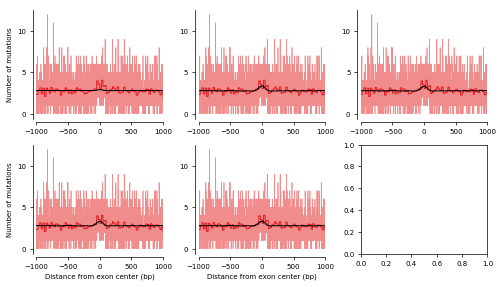

In [24]:
size = 25

listt = ['1mer_DNM_context_golden', 'CpG_DNM_context_golden', '3mer_DNM_context_golden',
         '5mer_DNM_context_golden', '7mer_DNM_context_golden']

NROW=2
NCOL=3

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_DNM_context_binned_golden.svg'), bbox_inches='tight')
plt.show()

## Exons centered analysis, DNM

Mutation probabilities were computed genome-wide using DNM. They were used to compute the expected number of mutations based on a generalized k-mer model, with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. for the 3-mer case.

In [12]:
## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df['ID'] = mutations_df.index + 1

tumor_type = 'germinal'

### 1-mer context dependency

In [13]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780


### 1-mer context dependency, 9 classes with CpG

In [14]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_CpG(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_CpG_DNM_context.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780


### 3-mer context dependency

In [15]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780


### 5-mer context dependency

In [16]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780


### 7-mer context dependency

In [17]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780


### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


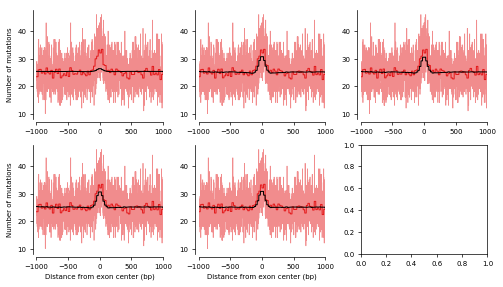

In [18]:
size = 25

listt = ['1mer_DNM_context', 'CpG_DNM_context', '3mer_DNM_context',
         '5mer_DNM_context', '7mer_DNM_context']

NROW=2
NCOL=3

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_DNM_context_binned.svg'), bbox_inches='tight')
plt.show()

### Plot results

Polynomial fit approach.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


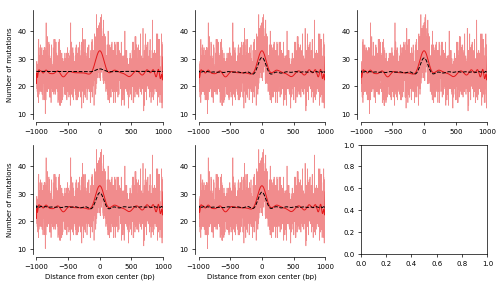

In [19]:
listt = ['1mer_DNM_context', 'CpG_DNM_context', '3mer_DNM_context',
         '5mer_DNM_context', '7mer_DNM_context']

NROW=2
NCOL=3

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD(ele, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_DNM_context_polynomial.svg'), bbox_inches='tight')
plt.show()